In [60]:
import os
import json
import pandas as pd
import numpy as np
import re

pd.set_option('display.max_rows', 10)
mvc_properties = ["ICNB", "GCNB", "LCMB", "GCPB", "LCNB"]
property_dict = {1: "ICNB", 2: "GCNB", 3: "LCMB", 4: "GCPB", 5: "LCNB"}
iv_list = [3, 4]
sl_list = [1, 2, 3, 5]
k_relax_list = [2, 3, 5]

mvc_str = "mvc_properties"
read_str = "read_behavior"
write_str = "write_behavior"
iv_str = "invisibility"
sl_str = "staleness"
tt_str = "total_time"
iv_sl_str = "iv_sl"
run_str = "RUN"
interval_str = "refresh_interval"
vp_range_str = "viewport_range"
vp_shift_str = "shift_step"
explore_str = "explore_range"
agg_value = "mean"
k_str = "k_relaxed"
one_k=1000



notebook_home= os.path.abspath('')
experiment_home=notebook_home + "/../experiment_results"

# parse a stat report
def parse_stat_report(file_path: str):
    with open(file_path) as json_file:
        return json.load(json_file)
    
def parse_int(filename: str) -> int:
    start = re.search(r"\d", filename).start()
    return int(filename[start:])

def add_error_bound(df):
    df = df.reset_index()
    df["lower"] = df[agg_value] - df["min"]
    df["upper"] = df["max"] - df[agg_value]
    df = df.drop(["max", "min"], axis =1)
    return df

def massage_data(df, metric_type, k_relaxed = False):
    #new_df = df[metric_type]/df[tt_str]
    new_df = df[metric_type]/one_k
    new_df = add_error_bound(new_df)
    if k_relaxed:
        new_df = new_df[new_df[mvc_str].isin(k_relax_list)]
    elif metric_type == iv_str:
        new_df = new_df[new_df[mvc_str].isin(iv_list)]
    elif metric_type == sl_str:
        new_df = new_df[new_df[mvc_str].isin(sl_list)]
    new_df[mvc_str] = new_df[mvc_str].apply(lambda x: property_dict[x] if x in property_dict else x)
    return new_df
    

def read_one_file(df, root, file, dim_one, dim_two):
    result = parse_stat_report(os.path.join(root, file))
    run = parse_int(os.path.basename(root))
    dim_one_result = result[dim_one]
    dim_two_result = int(result[dim_two])
    iv = float(result[iv_str])
    sl = float(result[sl_str])
    iv_sl = iv + sl
    vp_range = float(result[vp_range_str])
    tt = float(result[tt_str])/vp_range
    df.loc[len(df.index)] = [dim_one_result, dim_two_result, run, iv, sl, iv_sl, tt]

def read_raw_data(result_home, dim_one, dim_two):
    df = pd.DataFrame(columns=[dim_one, dim_two, run_str, iv_str, sl_str, iv_sl_str, tt_str])
    for root, dirs, files in os.walk(result_home):
        for file in files:
            if file == "stat.out":
                read_one_file(df, root, file, dim_one, dim_two)
    return df

def read_raw_data_by_dir_name(result_home, dim_one, dim_two):
    df = pd.DataFrame(columns=[dim_one, dim_two, run_str, iv_str, sl_str, iv_sl_str, tt_str])
    for dir_name in os.listdir(result_home):
        dir_root = os.path.join(result_home, dir_name)
        for root, dirs, files in os.walk(dir_root):
            for file in files:
                if file == "stat.out":
                    read_one_file(df, root, file, dim_one, dim_two)
    return df

In [61]:
#Color configuration
import matplotlib.cm as cm
from matplotlib import rcParams
GRAPH_COLOR = cm.YlGnBu
mvc_color_dict = {"ICNB": GRAPH_COLOR(90),
              "GCNB": GRAPH_COLOR(140),
              "LCMB": GRAPH_COLOR(190),
              "GCPB": GRAPH_COLOR(240),
              "LCNB": GRAPH_COLOR(300)}
def to_color(mvc):
    return color_dict[mvc]

# font
rcParams['font.family'] = 'Serif'
legend_size = 15
x_label_size = 20
y_label_size = 20
x_tick_size = 20
y_tick_size = 20

# Fig size
fig_width=8
fig_height=5

config_name_dict = {
    explore_str: "Explore Range",
    vp_range_str: "Viewport Size",
    vp_shift_str: "Shift Step",
    iv_str: "Invisibility (s)",
    sl_str: "Staleness (s)",
    k_str: "Number of UCs Relaxed"
}

# mapping to the names we want to use in the plots
mvc_name_dict = {"ICNB": "ICNB",
             "GCNB": "GCNB",
             "LCMB": "LCMB",
             "GCPB": "GCPB",
             "LCNB": "LCNB"}
k_mvc_name_dict = {"GCNB": "k-GCNB",
                   "LCMB": "k-LCMB",
                   "LCNB": "k-LCNB"}

read_name_dict = {"regular_change": "Regular Move",
                  "see_change": "Wait and Move",
                  "random_regular_change": "Random Move"}

mvc_marker_dict={"ICNB": "o",
             "GCNB": "v",
             "LCMB": "^",
             "GCPB": "s",
             "LCNB": "*"}
mvc_marker_size=10

In [62]:
import matplotlib.pyplot as plt

def draw_group_bar_charts(df,
                          group_label_header,
                          bar_label_header,
                          y_axis_header,
                          y_label,
                          fig_size,
                          bar_width,
                          y_tick_max,
                          y_tick_num,
                          legend_size,
                          x_tick_size,
                          y_tick_size,
                          y_label_size,
                          group_label_dict,
                          bar_label_dict,
                          bar_label_color_dict,
                          pdf_path,
                          ncol=4):
    group_labels = [group_label_dict[old_label] for old_label in df[group_label_header].unique()]
    bar_labels = df[bar_label_header].unique()

    x_ticks = np.arange(len(group_labels))  # the group label locations
    num_bars = len(bar_labels)

    fig, ax = plt.subplots(figsize=fig_size)
    for idx, bar_label in enumerate(bar_labels):
        df_subgroup = df[df[bar_label_header] == bar_label]
        err = df_subgroup[["lower", "upper"]].values.transpose()
        rect = ax.bar(x_ticks - ((num_bars - 1) * bar_width)/2 + idx * bar_width,
                      df_subgroup[y_axis_header].values,
                      bar_width, yerr=err, label=bar_label_dict[bar_label],
                      color=bar_label_color_dict[bar_label], ecolor="red")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(y_label, fontsize=y_label_size)
    y_ticks = np.arange(0, y_tick_max+0.1, step=y_tick_max/y_tick_num).astype(int)
    ax.set_yticks(y_ticks, y_ticks, fontsize=y_tick_size)
    ax.set_xticks(x_ticks, group_labels, fontsize=x_tick_size)
    ax.legend(fontsize=legend_size, ncol=ncol)
    fig.tight_layout()
    
    plt.savefig(pdf_path)
    plt.show()

def plot_line_chart(df,
                    x_axis_header,
                    y_axis_header,
                    line_label_header,
                    x_label,
                    y_label,
                    fig_size,
                    y_tick_max,
                    y_tick_num,
                    x_tick_min,
                    x_tick_max,
                    x_tick_num,
                    legend_size,
                    tick_size,
                    label_size,
                    line_label_dict,
                    line_label_color_dict,
                    marker_dict,
                    marker_size,
                    pdf_path,
                    ncol=2):
    line_labels = df[line_label_header].unique()
    fig, ax = plt.subplots(figsize=fig_size)
    for line_label in line_labels:
        df_subgroup = df[df[line_label_header] == line_label]
        #err = df_subgroup[["lower", "upper"]].values.transpose()
        #line = ax.errorbar(df_subgroup[x_axis_header].values, df_subgroup[y_axis_header].values, yerr=err, label=line_label)
        line = ax.plot(df_subgroup[x_axis_header].values,
                       df_subgroup[y_axis_header].values,
                       label=line_label_dict[line_label],
                       color=line_label_color_dict[line_label],
                       marker=marker_dict[line_label],
                       markersize=marker_size)
    
    ax.set_ylabel(y_label, fontsize=label_size)
    ax.set_xlabel(x_label, fontsize=label_size)
    y_ticks = np.arange(0, y_tick_max+0.1, step=y_tick_max/y_tick_num).astype(int)
    x_ticks = np.arange(x_tick_min, x_tick_max+0.1, step=(x_tick_max - x_tick_min)/x_tick_num).astype(int)
    ax.set_yticks(y_ticks, y_ticks, fontsize=tick_size)
    ax.set_xticks(x_ticks, x_ticks, fontsize=tick_size)
    ax.legend(fontsize=legend_size, ncol=ncol)
    fig.tight_layout()
    
    plt.savefig(pdf_path)
    plt.show()

## Plots for different read behaviors

In [63]:
read_behavior_results =  os.path.join(experiment_home, read_str)
df = read_raw_data_by_dir_name(read_behavior_results, read_str, mvc_str)
agg_df = df.drop([run_str], axis=1).groupby([read_str, mvc_str]).agg([agg_value, "min", "max"])
iv_df = massage_data(agg_df, iv_str)
iv_df

,read_behavior,mvc_properties,mean,lower,upper
2,random_regular_change,LCMB,3.1920,3.1920,6.6920
3,random_regular_change,GCPB,66.7740,7.8820,14.4320
7,regular_change,LCMB,11.6771,2.1221,2.1979
8,regular_change,GCPB,68.7619,3.1709,3.1941
12,see_change,LCMB,42.8131,1.7401,1.2539
13,see_change,GCPB,67.8197,1.8887,2.0673


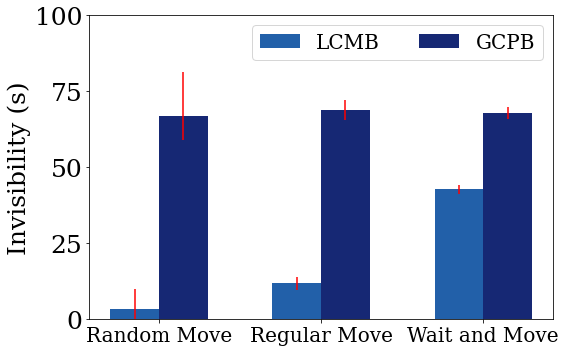

In [64]:
read_iv_fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{read_str}_iv.pdf'
read_x_tick_size = 20
read_y_tick_size = 25
read_label_size = 25
read_legend_size = 20
draw_group_bar_charts(df=iv_df,
                      group_label_header=read_str,
                      bar_label_header=mvc_str,
                      y_axis_header=agg_value,
                      y_label=config_name_dict[iv_str],
                      fig_size=read_iv_fig_size,
                      y_tick_max=100,
                      y_tick_num=4,
                      bar_width=0.3,
                      legend_size=read_legend_size,
                      x_tick_size=read_x_tick_size,
                      y_tick_size=read_y_tick_size,
                      y_label_size=read_label_size,
                      group_label_dict=read_name_dict,
                      bar_label_dict=mvc_name_dict,
                      bar_label_color_dict=mvc_color_dict,
                      pdf_path=pdf_path)

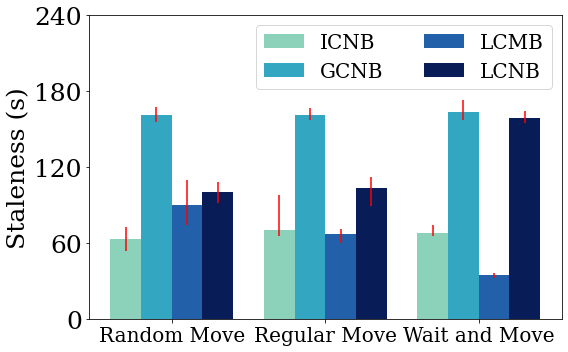

In [65]:
sl_df = massage_data(agg_df, sl_str)
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{read_str}_sl.pdf'
draw_group_bar_charts(df=sl_df,
                      group_label_header=read_str,
                      bar_label_header=mvc_str,
                      y_axis_header=agg_value,
                      y_label=config_name_dict[sl_str],
                      fig_size=fig_size,
                      y_tick_max=240,
                      y_tick_num=4,
                      bar_width=0.2,
                      legend_size=read_legend_size,
                      x_tick_size=read_x_tick_size,
                      y_tick_size=read_y_tick_size,
                      y_label_size=read_label_size,
                      group_label_dict=read_name_dict,
                      bar_label_dict=mvc_name_dict,
                      bar_label_color_dict=mvc_color_dict,
                      pdf_path=pdf_path,
                      ncol=2)

In [66]:
lcmb = iv_df[iv_df[mvc_str] == "LCMB"].reset_index()
gcpb = iv_df[iv_df[mvc_str] == "GCPB"].reset_index()
1.0 - lcmb[agg_value]/gcpb[agg_value]

0    0.952197
1    0.830181
2    0.368722
Name: mean, dtype: float64

In [67]:
lcmb = sl_df[sl_df[mvc_str] == "LCMB"].reset_index()
gcnb = sl_df[sl_df[mvc_str] == "GCNB"].reset_index()
1.0 - lcmb[agg_value]/gcnb[agg_value]

0    0.441131
1    0.586136
2    0.788590
Name: mean, dtype: float64

In [68]:
read_behavior = 'regular_change'
iv_sl_df = agg_df[[iv_str, sl_str]].iloc[:, [0, 3]]/one_k
iv_sl_df.columns = iv_sl_df.columns.get_level_values(0)
iv_sl_df = iv_sl_df.reset_index()
iv_sl_df[mvc_str] = iv_sl_df[mvc_str].apply(lambda x: property_dict[x] if x in property_dict else x)
iv_sl_df = iv_sl_df[iv_sl_df[read_str] == read_behavior]
iv_sl_df

,read_behavior,mvc_properties,invisibility,staleness
5,regular_change,ICNB,0.0000,70.4306
6,regular_change,GCNB,0.0000,161.4416
7,regular_change,LCMB,11.6771,66.8148
8,regular_change,GCPB,68.7619,0.0000
9,regular_change,LCNB,0.0000,103.5684


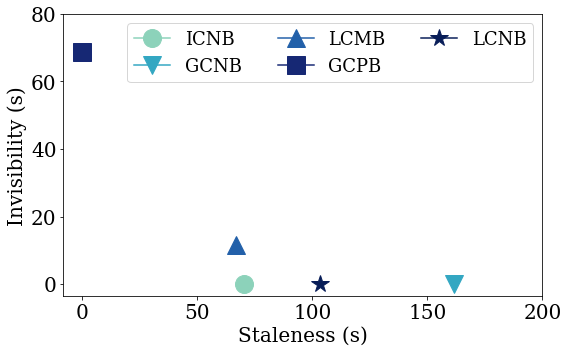

In [69]:
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{read_behavior}_iv_sl.pdf'
trade_tick_size = 20
trade_label_size = 20
trade_legend_size = 18
trade_marker_size = 18
plot_line_chart(df=iv_sl_df,
                x_axis_header=sl_str,
                y_axis_header=iv_str,
                line_label_header=mvc_str,
                x_label=config_name_dict[sl_str],
                y_label=config_name_dict[iv_str],
                fig_size=fig_size,
                y_tick_max=80,
                y_tick_num=4,
                x_tick_min=0,
                x_tick_max=200,
                x_tick_num=4,
                legend_size=trade_legend_size,
                tick_size=trade_tick_size,
                label_size=trade_label_size,
                line_label_dict=mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=trade_marker_size,
                pdf_path=pdf_path,
                ncol=3)

## Plots for different explore ranges

In [70]:
regular_change_results =  os.path.join(experiment_home, explore_str)
df = read_raw_data_by_dir_name(regular_change_results, explore_str, mvc_str)
agg_df = df.drop([run_str], axis=1).groupby([explore_str, mvc_str]).agg([agg_value, "min", "max"])
iv_df = massage_data(agg_df, iv_str)
iv_df

,explore_range,mvc_properties,mean,lower,upper
2,4.0,LCMB,0.000000,0.000000,0.000000
3,4.0,GCPB,24.355333,1.141333,1.363667
7,10.0,LCMB,3.228000,1.052000,1.067000
8,10.0,GCPB,29.327333,0.785333,0.808667
12,16.0,LCMB,6.341667,0.143667,0.219333
13,16.0,GCPB,46.574333,0.632333,0.909667
17,22.0,LCMB,12.655000,0.832000,1.514000
18,22.0,GCPB,68.063000,0.938000,1.114000


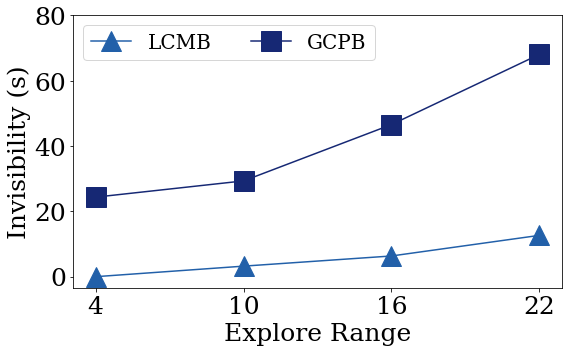

In [71]:
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{explore_str}_iv.pdf'
explore_tick_size = 25
explore_label_size = 25
explore_legend_size = 20
explore_marker_size = 20
plot_line_chart(df=iv_df,
                x_axis_header=explore_str,
                y_axis_header=agg_value,
                line_label_header=mvc_str,
                x_label=config_name_dict[explore_str],
                y_label=config_name_dict[iv_str],
                fig_size=fig_size,
                y_tick_max=80,
                y_tick_num=4,
                x_tick_min=4,
                x_tick_max=22,
                x_tick_num=3,
                legend_size=explore_legend_size,
                tick_size=explore_tick_size,
                label_size=explore_label_size,
                line_label_dict=mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=explore_marker_size,
                pdf_path=pdf_path)

In [72]:
sl_df = massage_data(agg_df, sl_str)
sl_df

,explore_range,mvc_properties,mean,lower,upper
0,4.0,ICNB,24.217667,0.402667,0.581333
1,4.0,GCNB,160.869333,4.417333,4.602667
2,4.0,LCMB,34.748000,1.136000,1.456000
4,4.0,LCNB,34.376000,0.672000,1.028000
5,10.0,ICNB,29.535667,0.996667,0.702333
...,...,...,...,...,...
14,16.0,LCNB,65.120000,0.524000,0.756000
15,22.0,ICNB,67.760333,0.416333,0.304667
16,22.0,GCNB,159.157333,3.229333,3.114667
17,22.0,LCMB,63.137333,3.093333,5.378667


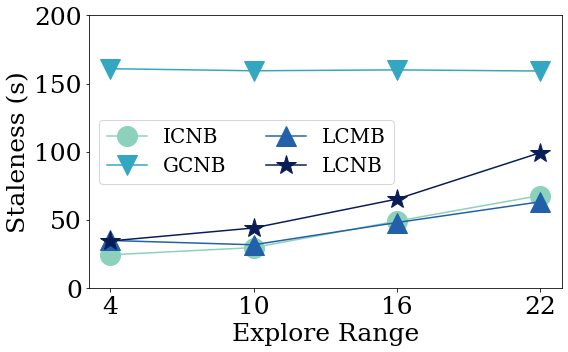

In [73]:
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{explore_str}_sl.pdf'
plot_line_chart(df=sl_df,
                x_axis_header=explore_str,
                y_axis_header=agg_value,
                line_label_header=mvc_str,
                x_label=config_name_dict[explore_str],
                y_label=config_name_dict[sl_str],
                fig_size=fig_size,
                y_tick_max=200,
                y_tick_num=4,
                x_tick_min=4,
                x_tick_max=22,
                x_tick_num=3,
                legend_size=explore_legend_size,
                tick_size=explore_tick_size,
                label_size=explore_label_size,
                line_label_dict=mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=explore_marker_size,
                pdf_path=pdf_path)

## Plots for different viewport size

In [74]:
viewport_range =  os.path.join(experiment_home, "dash_config", vp_range_str)
df = read_raw_data(viewport_range, vp_range_str, mvc_str)
df = df.sort_values([vp_range_str, mvc_str, run_str])
agg_df = df.drop([run_str], axis=1).groupby([vp_range_str, mvc_str]).agg([agg_value, "min", "max"])
iv_df = massage_data(agg_df, iv_str)
agg_df

invisibility                      \
                                        mean       min       max   
viewport_range mvc_properties                                      
4.0            1.0                  0.000000       0.0       0.0   
               2.0                  0.000000       0.0       0.0   
               3.0              12784.000000   12462.0   13131.0   
               4.0              67956.333333   66426.0   70566.0   
               5.0                  0.000000       0.0       0.0   
...                                      ...       ...       ...   
22.0           1.0                  0.000000       0.0       0.0   
               2.0                  0.000000       0.0       0.0   
               3.0                  0.000000       0.0       0.0   
               4.0             362711.666667  354754.0  376740.0   
               5.0                  0.000000       0.0       0.0   

                                   staleness                      \
                                        mean       min       max   
viewport_range mvc_properties                                      
4.0            1.0              69040.000000   66591.0   71681.0   
               2.0             162502.666667  160256.0  165932.0   
               3.0              63582.666667   60184.0   69348.0   
               4.0                  0.000000       0.0       0.0   
               5.0             102690.666667  102164.0  103136.0   
...                                      ...       ...       ...   
22.0           1.0             363131.333333  350360.0  371781.0   
               2.0             911452.666667  858704.0  946286.0   
               3.0             890897.333333  866734.0  924990.0   
               4.0                  0.000000       0.0       0.0   
               5.0             871948.000000  864908.0  875534.0   

                                       iv_sl                      \
                                        mean       min       max   
viewport_range mvc_properties                                      
4.0            1.0              69040.000000   66591.0   71681.0   
               2.0             162502.666667  160256.0  165932.0   
               3.0              76366.666667   72943.0   82479.0   
               4.0              67956.333333   66426.0   70566.0   
               5.0             102690.666667  102164.0  103136.0   
...                                      ...       ...       ...   
22.0           1.0             363131.333333  350360.0  371781.0   
               2.0             911452.666667  858704.0  946286.0   
               3.0             890897.333333  866734.0  924990.0   
               4.0             362711.666667  354754.0  376740.0   
               5.0             871948.000000  864908.0  875534.0   

                                 total_time                    
                                       mean      min      max  
viewport_range mvc_properties                                  
4.0            1.0             40644.666667  39954.0  41025.0  
               2.0             40763.333333  40196.0  41635.0  
               3.0             40754.666667  40298.0  41582.0  
               4.0             40737.333333  39959.0  41858.0  
               5.0             40836.333333  39604.0  41657.0  
...                                     ...      ...      ...  
22.0           1.0             41100.666667  39713.0  42173.0  
               2.0             41639.000000  39210.0  43259.0  
               3.0             40684.333333  39593.0  42225.0  
               4.0             40917.333333  40224.0  41814.0  
               5.0             39828.000000  39508.0  40005.0  

[20 rows x 12 columns]

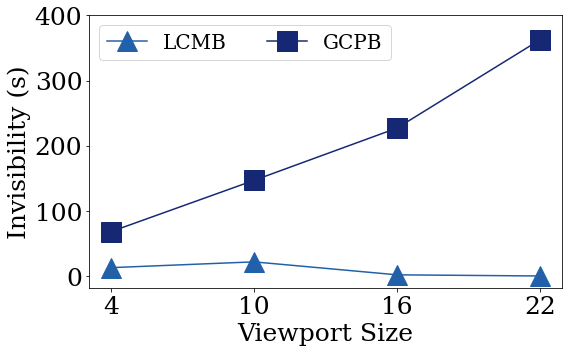

In [75]:
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{vp_range_str}_iv.pdf'
viewport_tick_size = 25
viewport_label_size = 25
viewport_legend_size = 20
viewport_marker_size = 20
plot_line_chart(df=iv_df,
                x_axis_header=vp_range_str,
                y_axis_header=agg_value,
                line_label_header=mvc_str,
                x_label=config_name_dict[vp_range_str],
                y_label=config_name_dict[iv_str],
                fig_size=fig_size,
                y_tick_max=400,
                y_tick_num=4,
                x_tick_min=4,
                x_tick_max=22,
                x_tick_num=3,
                legend_size=viewport_legend_size,
                tick_size=viewport_tick_size,
                label_size=viewport_label_size,
                line_label_dict=mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=viewport_marker_size,
                pdf_path=pdf_path)

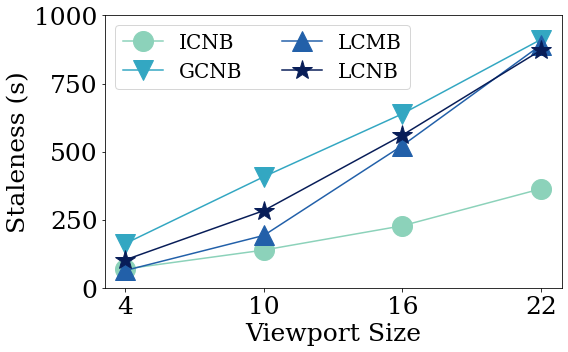

In [76]:
sl_df = massage_data(agg_df, sl_str)
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{vp_range_str}_sl.pdf'
plot_line_chart(df=sl_df,
                x_axis_header=vp_range_str,
                y_axis_header=agg_value,
                line_label_header=mvc_str,
                x_label=config_name_dict[vp_range_str],
                y_label=config_name_dict[sl_str],
                fig_size=fig_size,
                y_tick_max=1000,
                y_tick_num=4,
                x_tick_min=4,
                x_tick_max=22,
                x_tick_num=3,
                legend_size=viewport_legend_size,
                tick_size=viewport_tick_size,
                label_size=viewport_label_size,
                line_label_dict=mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=viewport_marker_size,
                pdf_path=pdf_path)

## Plots for different k-relaxed

In [77]:
read_behavior = "regular_move"
k_path =  os.path.join(experiment_home, f'{k_str}_{read_behavior}')
df = read_raw_data(k_path, k_str, mvc_str)
df = df.sort_values([k_str, mvc_str, run_str])
agg_df = df.drop([run_str], axis=1).groupby([k_str, mvc_str]).agg([agg_value, "min", "max"])
iv_df = massage_data(agg_df, iv_str, True)
iv_df

,k_relaxed,mvc_properties,mean,lower,upper
0,0.0,GCNB,0.000000,0.000000,0.000000
1,0.0,LCMB,12.059000,1.834000,1.574000
2,0.0,LCNB,0.000000,0.000000,0.000000
3,2.0,GCNB,1.959667,0.312667,0.166333
4,2.0,LCMB,14.770667,2.813667,3.533333
...,...,...,...,...,...
31,20.0,LCMB,67.204000,0.980000,0.650000
32,20.0,LCNB,67.512000,2.953000,2.524000
33,22.0,GCNB,66.840333,2.822333,2.015667
34,22.0,LCMB,67.989000,2.691000,4.508000


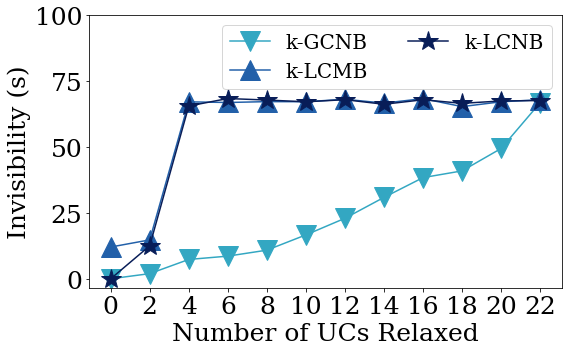

In [78]:
fig_size = (fig_width, fig_height)
k_tick_size = 25
k_label_size = 25
k_legend_size = 20
k_marker_size = 20
pdf_path = f'{notebook_home}/{k_str}_iv.pdf'
plot_line_chart(df=iv_df,
                x_axis_header=k_str,
                y_axis_header=agg_value,
                line_label_header=mvc_str,
                x_label=config_name_dict[k_str],
                y_label=config_name_dict[iv_str],
                fig_size=fig_size,
                y_tick_max=100,
                y_tick_num=4,
                x_tick_min=0,
                x_tick_max=22,
                x_tick_num=11,
                legend_size=k_legend_size,
                tick_size=k_tick_size,
                label_size=k_label_size,
                line_label_dict=k_mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=k_marker_size,
                pdf_path=pdf_path)

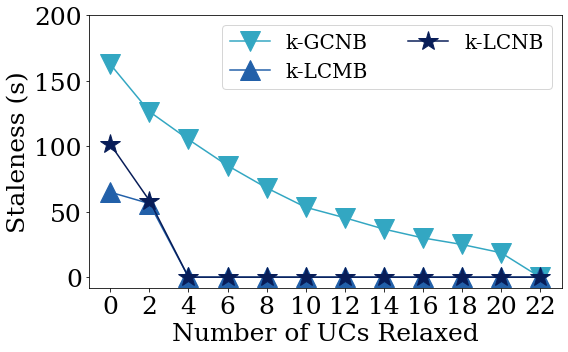

In [79]:
sl_df = massage_data(agg_df, sl_str, True)
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{k_str}_sl.pdf'
plot_line_chart(df=sl_df,
                x_axis_header=k_str,
                y_axis_header=agg_value,
                line_label_header=mvc_str,
                x_label=config_name_dict[k_str],
                y_label=config_name_dict[sl_str],
                fig_size=fig_size,
                y_tick_max=200,
                y_tick_num=4,
                x_tick_min=0,
                x_tick_max=22,
                x_tick_num=11,
                legend_size=k_legend_size,
                tick_size=k_tick_size,
                label_size=k_label_size,
                line_label_dict=k_mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=k_marker_size,
                pdf_path=pdf_path)

In [80]:
iv_sl_df = agg_df[[iv_str, sl_str]].iloc[:, [0, 3]]/one_k
iv_sl_df.columns = iv_sl_df.columns.get_level_values(0)
iv_sl_df = iv_sl_df.reset_index()
iv_sl_df[mvc_str] = iv_sl_df[mvc_str].apply(lambda x: property_dict[x] if x in property_dict else x)
#iv_sl_df = iv_sl_df[(iv_sl_df['mvc_properties'] == 'LCMB') | (iv_sl_df['mvc_properties'] == 'GCNB')]

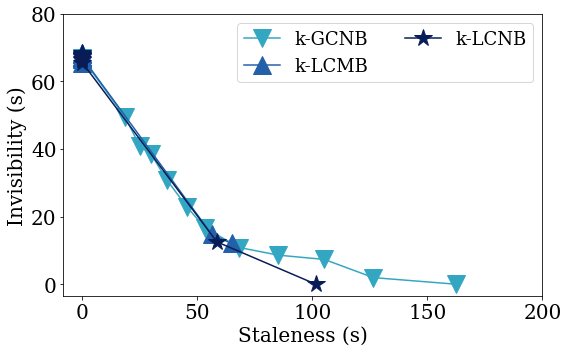

In [81]:
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{k_str}_{read_behavior}_iv_sl.pdf'
trace_tick_size = 20
trace_label_size = 20
trace_legend_size = 18
trace_marker_size = 18
plot_line_chart(df=iv_sl_df,
                x_axis_header=sl_str,
                y_axis_header=iv_str,
                line_label_header=mvc_str,
                x_label=config_name_dict[sl_str],
                y_label=config_name_dict[iv_str],
                fig_size=fig_size,
                y_tick_max=80,
                y_tick_num=4,
                x_tick_min=0,
                x_tick_max=200,
                x_tick_num=4,
                legend_size=trace_legend_size,
                tick_size=trace_tick_size,
                label_size=trace_label_size,
                line_label_dict=k_mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=trace_marker_size,
                pdf_path=pdf_path)

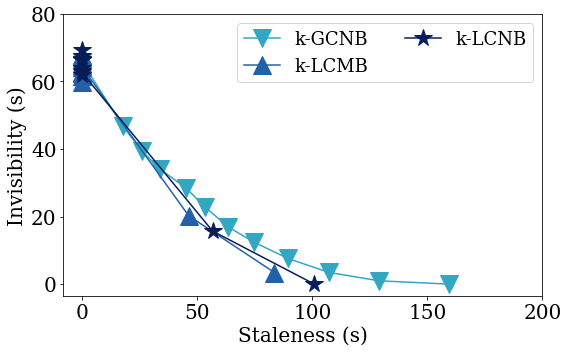

In [82]:
read_behavior = "random_move"
k_path =  os.path.join(experiment_home, f'{k_str}_{read_behavior}')
df = read_raw_data(k_path, k_str, mvc_str)
df = df.sort_values([k_str, mvc_str, run_str])
agg_df = df.drop([run_str], axis=1).groupby([k_str, mvc_str]).agg([agg_value, "min", "max"])
iv_sl_df = agg_df[[iv_str, sl_str]].iloc[:, [0, 3]]/one_k
iv_sl_df.columns = iv_sl_df.columns.get_level_values(0)
iv_sl_df = iv_sl_df.reset_index()
iv_sl_df[mvc_str] = iv_sl_df[mvc_str].apply(lambda x: property_dict[x] if x in property_dict else x)
pdf_path = f'{notebook_home}/{k_str}_{read_behavior}_iv_sl.pdf'
trace_tick_size = 20
trace_label_size = 20
trace_legend_size = 18
trace_marker_size = 18
plot_line_chart(df=iv_sl_df,
                x_axis_header=sl_str,
                y_axis_header=iv_str,
                line_label_header=mvc_str,
                x_label=config_name_dict[sl_str],
                y_label=config_name_dict[iv_str],
                fig_size=fig_size,
                y_tick_max=80,
                y_tick_num=4,
                x_tick_min=0,
                x_tick_max=200,
                x_tick_num=4,
                legend_size=trace_legend_size,
                tick_size=trace_tick_size,
                label_size=trace_label_size,
                line_label_dict=k_mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=trace_marker_size,
                pdf_path=pdf_path)

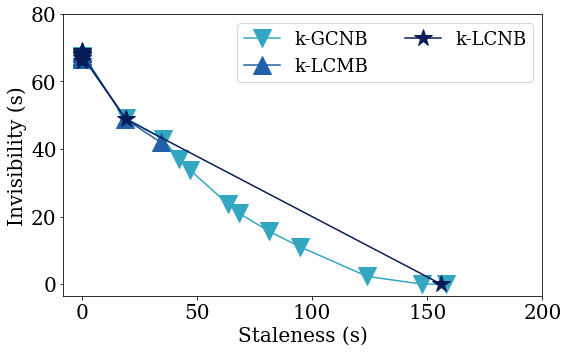

In [83]:
read_behavior = "see_move"
k_path =  os.path.join(experiment_home, f'{k_str}_{read_behavior}')
df = read_raw_data(k_path, k_str, mvc_str)
df = df.sort_values([k_str, mvc_str, run_str])
agg_df = df.drop([run_str], axis=1).groupby([k_str, mvc_str]).agg([agg_value, "min", "max"])
iv_sl_df = agg_df[[iv_str, sl_str]].iloc[:, [0, 3]]/one_k
iv_sl_df.columns = iv_sl_df.columns.get_level_values(0)
iv_sl_df = iv_sl_df.reset_index()
iv_sl_df[mvc_str] = iv_sl_df[mvc_str].apply(lambda x: property_dict[x] if x in property_dict else x)
pdf_path = f'{notebook_home}/{k_str}_{read_behavior}_iv_sl.pdf'
trace_tick_size = 20
trace_label_size = 20
trace_legend_size = 18
trace_marker_size = 18
plot_line_chart(df=iv_sl_df,
                x_axis_header=sl_str,
                y_axis_header=iv_str,
                line_label_header=mvc_str,
                x_label=config_name_dict[sl_str],
                y_label=config_name_dict[iv_str],
                fig_size=fig_size,
                y_tick_max=80,
                y_tick_num=4,
                x_tick_min=0,
                x_tick_max=200,
                x_tick_num=4,
                legend_size=trace_legend_size,
                tick_size=trace_tick_size,
                label_size=trace_label_size,
                line_label_dict=k_mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=trace_marker_size,
                pdf_path=pdf_path)

## Plots for Invisibility and Staleness Trace

In [84]:
log_time_str = "log_time"
def parse_iv_sl_report(df, file_path: str):
    with open(file_path) as fp:
        json_objects = fp.read()
        json_objects = json_objects.replace('}{', '}\n\n{')
        json_objects = json_objects.split('\n\n')
        for (i, json_obj) in enumerate(json_objects):
            if i == 0:
                meta_info = json.loads(json_obj)
                mvc = int(meta_info[mvc_str])
            elif i >= 1:
                one_log = json.loads(json_obj)
                iv = float(one_log["iv"])
                sl = float(one_log["sl"])
                log_time = float(one_log[log_time_str])
                df.loc[len(df.index)] = [property_dict[mvc], log_time, iv, sl]
                
def load_iv_sl_data(result_home):
    df = pd.DataFrame(columns=[mvc_str, log_time_str, iv_str, sl_str])
    for root, dirs, files in os.walk(result_home):
        for file in files:
            if file == "iv_sl.log":
                parse_iv_sl_report(df, os.path.join(root, file))
    return df

def aggregate_iv_sl_data(new_df, df, agg_grain):
    start_mvc = ""
    start_log_time = 0.0
    agg_count = 0.0
    agg_iv = 0.0
    agg_sl = 0.0
    for _, row in df.iterrows():
        if row[log_time_str] - start_log_time > agg_grain:
            start_mvc = row[mvc_str]
            new_df.loc[len(new_df.index)] = [start_mvc, start_log_time/one_k, agg_iv/agg_count, agg_sl/agg_count]
            start_log_time = row[log_time_str]
            agg_count = 0.0
            agg_iv = 0.0
            agg_sl = 0.0
        agg_count += 1
        agg_iv += row[iv_str]
        agg_sl += row[sl_str]
    if agg_count != 0.0:
        new_df.loc[len(new_df.index)] = [start_mvc, start_log_time/one_k, agg_iv/agg_count, agg_sl/agg_count]

In [85]:
df = load_iv_sl_data(os.path.join(experiment_home, "trace"))
df

,mvc_properties,log_time,invisibility,staleness
0,GCPB,0.0,4.0,0.0
1,GCPB,2279.0,4.0,0.0
2,GCPB,2398.0,4.0,0.0
3,GCPB,2519.0,4.0,0.0
4,GCPB,2639.0,4.0,0.0
...,...,...,...,...
1449,LCNB,37170.0,0.0,0.0
1450,LCNB,37292.0,0.0,0.0
1451,LCNB,37415.0,0.0,0.0
1452,LCNB,37535.0,0.0,0.0


In [86]:
agg_grain = 2000
new_df = pd.DataFrame(columns=[mvc_str, log_time_str, iv_str, sl_str])
for mvc_value in df[mvc_str].unique():
    one_df = df[df[mvc_str] == mvc_value]
    #one_df = one_df.set_index([mvc_str, log_time_str])
    #one_df = one_df.rolling(n).mean()[(n-1)::n]
    #one_df = one_df.reset_index()
    aggregate_iv_sl_data(new_df, one_df, agg_grain)
    #new_df = pd.concat([new_df, one_df])
#new_df[log_time_str] = new_df[log_time_str].div(round_up_second)
#new_df[log_time_str] = new_df[log_time_str].apply(lambda x: round(x))
new_df

,mvc_properties,log_time,invisibility,staleness
0,GCPB,0.000,4.000000,0.000000
1,GCPB,2.279,4.000000,0.000000
2,GCPB,4.331,4.000000,0.000000
3,GCPB,6.411,3.470588,0.000000
4,GCPB,8.487,3.647059,0.000000
...,...,...,...,...
88,LCNB,27.322,0.000000,3.529412
89,LCNB,29.427,0.000000,1.882353
90,LCNB,31.508,0.000000,1.000000
91,LCNB,33.582,0.000000,0.000000


In [87]:
iv_df = new_df[(new_df[mvc_str] == 'GCPB') | (new_df[mvc_str] == 'LCMB')]
iv_df

,mvc_properties,log_time,invisibility,staleness
0,GCPB,0.000,4.000000,0.0
1,GCPB,2.279,4.000000,0.0
2,GCPB,4.331,4.000000,0.0
3,GCPB,6.411,3.470588,0.0
4,GCPB,8.487,3.647059,0.0
...,...,...,...,...
51,LCMB,29.573,0.647059,0.0
52,LCMB,31.647,0.062500,0.0
53,LCMB,33.658,0.000000,0.0
54,LCMB,35.770,0.000000,0.0


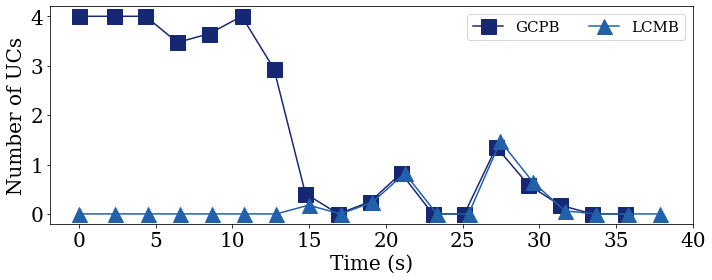

In [88]:
trace_fig_size = (fig_width+2, fig_height-1)
pdf_path = f'{notebook_home}/trace_iv.pdf'
log_time_label = "Time (s)"
iv_label = "Number of UCs"
sl_label = "Number of Stale Views"
trace_marker_size = 15
plot_line_chart(df=iv_df,
                x_axis_header=log_time_str,
                y_axis_header=iv_str,
                line_label_header=mvc_str,
                x_label=log_time_label,
                y_label=iv_label,
                fig_size=trace_fig_size,
                y_tick_max=4,
                y_tick_num=4,
                x_tick_min=0,
                x_tick_max=40,
                x_tick_num=8,
                legend_size=legend_size,
                tick_size=x_tick_size,
                label_size=y_label_size,
                line_label_dict=mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=trace_marker_size,
                pdf_path=pdf_path)

In [89]:
sl_df = new_df[(new_df[mvc_str] != 'GCPB')]
sl_df[sl_df[mvc_str] == 'GCNB']

,mvc_properties,log_time,invisibility,staleness
56,GCNB,0.000,0.0,4.000000
57,GCNB,2.465,0.0,4.000000
58,GCNB,4.576,0.0,4.000000
59,GCNB,6.664,0.0,4.000000
60,GCNB,8.674,0.0,4.000000
...,...,...,...,...
70,GCNB,29.430,0.0,4.000000
71,GCNB,31.547,0.0,4.000000
72,GCNB,33.630,0.0,4.000000
73,GCNB,35.745,0.0,4.000000


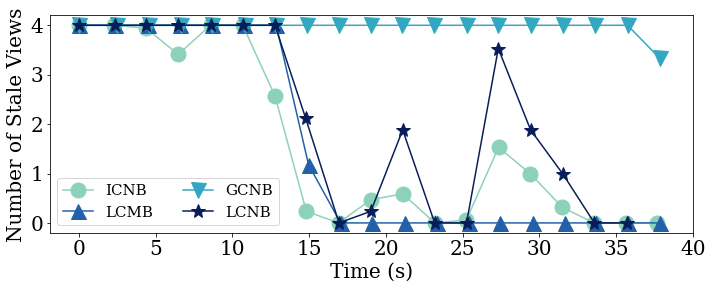

In [90]:
pdf_path = f'{notebook_home}/trace_sl.pdf'
plot_line_chart(df=sl_df,
                x_axis_header=log_time_str,
                y_axis_header=sl_str,
                line_label_header=mvc_str,
                x_label=log_time_label,
                y_label=sl_label,
                fig_size=trace_fig_size,
                y_tick_max=4,
                y_tick_num=4,
                x_tick_min=0,
                x_tick_max=40,
                x_tick_num=8,
                legend_size=legend_size,
                tick_size=x_tick_size,
                label_size=y_label_size,
                line_label_dict=mvc_name_dict,
                line_label_color_dict=mvc_color_dict,
                marker_dict=mvc_marker_dict,
                marker_size=trace_marker_size,
                pdf_path=pdf_path)

## Plots for scheduler optimizations

In [91]:
opt_name_dict = {"optimization_false_false": "NoOpt", 
                 "optimization_true_false": "Antifreeze",
                 "optimization_false_true": "Metrics",
                 "optimization_true_true": "TP"}
opt_color_dict = {"optimization_false_false": GRAPH_COLOR(120), 
                 "optimization_true_false": GRAPH_COLOR(180),
                 "optimization_false_true": GRAPH_COLOR(60),
                 "optimization_true_true": GRAPH_COLOR(240)}

opt_marker_dict = {"optimization_false_false": "o", 
                 "optimization_true_false": "v",
                 "optimization_false_true": "^",
                 "optimization_true_true": "s"}

opt_marker_size = 20

opt_viewport_str = "opt_viewport"
opt_exec_time_str = "opt_exec_time"
opt_str = "optimization"
opt_fig_size = (fig_width, fig_height)
opt_bar_width = 0.3
opt_iv_max = 80
opt_sl_max = 160
num_y_ticks = 4
ncol = 3
opt_legend_size = 18
def read_raw_data_for_optimizations(result_home):
    df = pd.DataFrame(columns=[mvc_str, opt_str, run_str, iv_str, sl_str, iv_sl_str, tt_str])
    for dir_name in os.listdir(result_home):
        dir_root = os.path.join(result_home, dir_name)
        for root, dirs, files in os.walk(dir_root):
            for file in files:
                if file == "stat.out":
                    result = parse_stat_report(os.path.join(root, file))
                    run = parse_int(os.path.basename(root))
                    mvc_result = result[mvc_str]
                    opt_result = f'{opt_str}_{result[opt_exec_time_str]}_{result[opt_viewport_str]}'
                    iv = float(result[iv_str])
                    sl = float(result[sl_str])
                    iv_sl = iv + sl
                    vp_range = float(result[vp_range_str])
                    tt = float(result[tt_str])/vp_range
                    df.loc[len(df.index)] = [mvc_result, opt_result.lower(), run, iv, sl, iv_sl, tt]
    return df

def read_raw_data_for_optimizations_new(result_home):
    df = pd.DataFrame(columns=[mvc_str, explore_str, opt_str, run_str, iv_str, sl_str, iv_sl_str, tt_str])
    for dir_name in os.listdir(result_home):
        dir_root = os.path.join(result_home, dir_name)
        for root, dirs, files in os.walk(dir_root):
            for file in files:
                if file == "stat.out":
                    result = parse_stat_report(os.path.join(root, file))
                    run = parse_int(os.path.basename(root))
                    mvc_result = result[mvc_str]
                    explore_result = result[explore_str]
                    opt_result = f'{opt_str}_{result[opt_exec_time_str]}_{result[opt_viewport_str]}'
                    iv = float(result[iv_str])
                    sl = float(result[sl_str])
                    iv_sl = iv + sl
                    vp_range = float(result[vp_range_str])
                    tt = float(result[tt_str])/vp_range
                    df.loc[len(df.index)] = [mvc_result, explore_result, opt_result.lower(), run, iv, sl, iv_sl, tt]
    return df

In [92]:
opt_path =  os.path.join(experiment_home, "optimization_explore_range")
df = read_raw_data_for_optimizations_new(opt_path)
df[mvc_str] = df[mvc_str].apply(lambda x: property_dict[x] if x in property_dict else x)
# df = df[df[opt_str] != "optimization_false_true"]
df = df.sort_values([mvc_str, explore_str, opt_str, run_str])
agg_df = df.drop([run_str], axis=1).groupby([mvc_str, explore_str, opt_str]).agg([agg_value, "min", "max"])
agg_df = agg_df/one_k

In [93]:
lm_iv_df = agg_df.loc['LCMB'][iv_str, agg_value].rename(agg_value).reset_index()
lm_iv_df

,explore_range,optimization,mean
0,4,optimization_false_false,0.000000
1,4,optimization_false_true,0.000000
2,4,optimization_true_false,0.000000
3,4,optimization_true_true,0.000000
4,10,optimization_false_false,7.547667
...,...,...,...
11,16,optimization_true_true,6.349333
12,22,optimization_false_false,14.629000
13,22,optimization_false_true,16.194667
14,22,optimization_true_false,10.647333


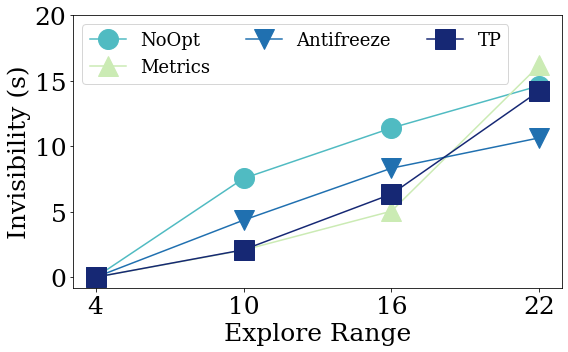

In [94]:
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{explore_str}_lcmb_iv.pdf'
plot_line_chart(df=lm_iv_df,
                x_axis_header=explore_str,
                y_axis_header=agg_value,
                line_label_header=opt_str,
                x_label=config_name_dict[explore_str],
                y_label=config_name_dict[iv_str],
                fig_size=fig_size,
                y_tick_max=20,
                y_tick_num=4,
                x_tick_min=4,
                x_tick_max=22,
                x_tick_num=3,
                legend_size=opt_legend_size,
                tick_size=explore_tick_size,
                label_size=explore_label_size,
                line_label_dict=opt_name_dict,
                line_label_color_dict=opt_color_dict,
                marker_dict=opt_marker_dict,
                marker_size=opt_marker_size,
                pdf_path=pdf_path,
                ncol=ncol)

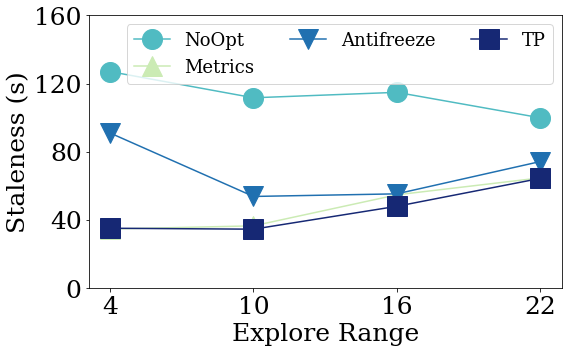

In [95]:
lm_sl_df = agg_df.loc['LCMB'][sl_str, agg_value].rename(agg_value).reset_index()
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{explore_str}_lcmb_sl.pdf'
plot_line_chart(df=lm_sl_df,
                x_axis_header=explore_str,
                y_axis_header=agg_value,
                line_label_header=opt_str,
                x_label=config_name_dict[explore_str],
                y_label=config_name_dict[sl_str],
                fig_size=fig_size,
                y_tick_max=160,
                y_tick_num=4,
                x_tick_min=4,
                x_tick_max=22,
                x_tick_num=3,
                legend_size=opt_legend_size,
                tick_size=explore_tick_size,
                label_size=explore_label_size,
                line_label_dict=opt_name_dict,
                line_label_color_dict=opt_color_dict,
                marker_dict=opt_marker_dict,
                marker_size=opt_marker_size,
                pdf_path=pdf_path,
                ncol=ncol)

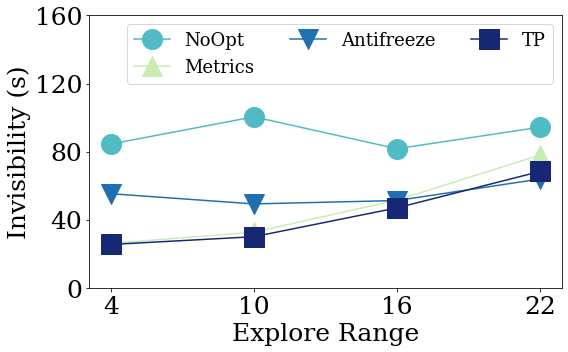

In [96]:
gp_iv_df = agg_df.loc['GCPB'][iv_str, agg_value].rename(agg_value).reset_index()
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{explore_str}_gcpb_iv.pdf'
plot_line_chart(df=gp_iv_df,
                x_axis_header=explore_str,
                y_axis_header=agg_value,
                line_label_header=opt_str,
                x_label=config_name_dict[explore_str],
                y_label=config_name_dict[iv_str],
                fig_size=fig_size,
                y_tick_max=160,
                y_tick_num=4,
                x_tick_min=4,
                x_tick_max=22,
                x_tick_num=3,
                legend_size=opt_legend_size,
                tick_size=explore_tick_size,
                label_size=explore_label_size,
                line_label_dict=opt_name_dict,
                line_label_color_dict=opt_color_dict,
                marker_dict=opt_marker_dict,
                marker_size=opt_marker_size,
                pdf_path=pdf_path,
                ncol=ncol)

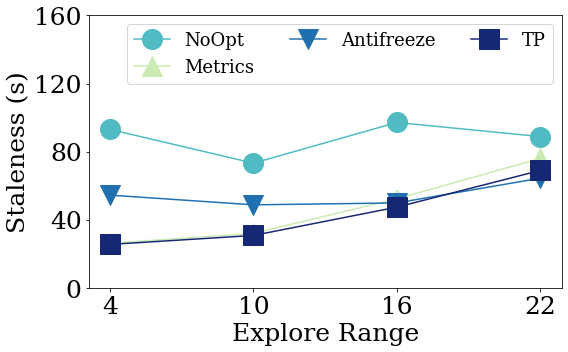

In [97]:
in_sl_df = agg_df.loc['ICNB'][sl_str, agg_value].rename(agg_value).reset_index()
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{explore_str}_icnb_sl.pdf'
plot_line_chart(df=in_sl_df,
                x_axis_header=explore_str,
                y_axis_header=agg_value,
                line_label_header=opt_str,
                x_label=config_name_dict[explore_str],
                y_label=config_name_dict[sl_str],
                fig_size=fig_size,
                y_tick_max=160,
                y_tick_num=4,
                x_tick_min=4,
                x_tick_max=22,
                x_tick_num=3,
                legend_size=opt_legend_size,
                tick_size=explore_tick_size,
                label_size=explore_label_size,
                line_label_dict=opt_name_dict,
                line_label_color_dict=opt_color_dict,
                marker_dict=opt_marker_dict,
                marker_size=opt_marker_size,
                pdf_path=pdf_path,
                ncol=ncol)

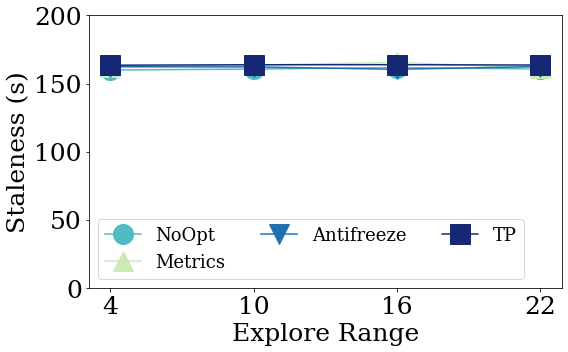

In [98]:
gn_sl_df = agg_df.loc['GCNB'][sl_str, agg_value].rename(agg_value).reset_index()
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{explore_str}_gcnb_sl.pdf'
plot_line_chart(df=gn_sl_df,
                x_axis_header=explore_str,
                y_axis_header=agg_value,
                line_label_header=opt_str,
                x_label=config_name_dict[explore_str],
                y_label=config_name_dict[sl_str],
                fig_size=fig_size,
                y_tick_max=200,
                y_tick_num=4,
                x_tick_min=4,
                x_tick_max=22,
                x_tick_num=3,
                legend_size=opt_legend_size,
                tick_size=explore_tick_size,
                label_size=explore_label_size,
                line_label_dict=opt_name_dict,
                line_label_color_dict=opt_color_dict,
                marker_dict=opt_marker_dict,
                marker_size=opt_marker_size,
                pdf_path=pdf_path,
                ncol=ncol)

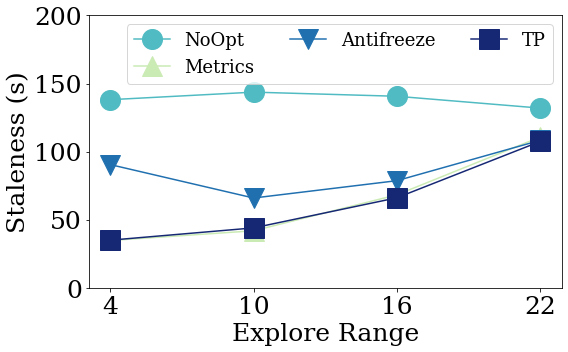

In [99]:
ln_sl_df = agg_df.loc['LCNB'][sl_str, agg_value].rename(agg_value).reset_index()
fig_size = (fig_width, fig_height)
pdf_path = f'{notebook_home}/{explore_str}_lcnb_sl.pdf'
plot_line_chart(df=ln_sl_df,
                x_axis_header=explore_str,
                y_axis_header=agg_value,
                line_label_header=opt_str,
                x_label=config_name_dict[explore_str],
                y_label=config_name_dict[sl_str],
                fig_size=fig_size,
                y_tick_max=200,
                y_tick_num=4,
                x_tick_min=4,
                x_tick_max=22,
                x_tick_num=3,
                legend_size=opt_legend_size,
                tick_size=explore_tick_size,
                label_size=explore_label_size,
                line_label_dict=opt_name_dict,
                line_label_color_dict=opt_color_dict,
                marker_dict=opt_marker_dict,
                marker_size=opt_marker_size,
                pdf_path=pdf_path,
                ncol=ncol)

In [100]:
new_gp_iv_df = gp_iv_df.set_index([explore_str, opt_str])
1 - new_gp_iv_df.loc[10, 'optimization_true_true']/new_gp_iv_df.loc[10, 'optimization_false_false']

mean    0.701264
dtype: float64

In [101]:
1 - new_gp_iv_df.loc[4, 'optimization_true_true']/new_gp_iv_df.loc[4, 'optimization_true_false']

mean    0.539603
dtype: float64

In [102]:
new_lm_iv_df = lm_iv_df.set_index([explore_str, opt_str])
new_lm_iv_df.loc[22, 'optimization_true_true']/new_lm_iv_df.loc[22, 'optimization_true_false']
new_lm_iv_df.loc[22]

,mean
optimization,
optimization_false_false,14.629000
optimization_false_true,16.194667
optimization_true_false,10.647333
optimization_true_true,14.241667


In [103]:
new_df = in_sl_df.set_index([explore_str, opt_str])
[1 - new_df.loc[4, 'optimization_true_true']/new_df.loc[4, 'optimization_false_false'],
 1 - new_df.loc[4, 'optimization_true_true']/new_df.loc[4, 'optimization_true_false']]

[mean    0.725918
 dtype: float64,
 mean    0.531674
 dtype: float64]

In [104]:
new_df = lm_sl_df.set_index([explore_str, opt_str])
[1 - new_df.loc[4, 'optimization_true_true']/new_df.loc[4, 'optimization_false_false'],
 1 - new_df.loc[4, 'optimization_true_true']/new_df.loc[4, 'optimization_true_false']]

[mean    0.724505
 dtype: float64,
 mean    0.615135
 dtype: float64]

In [105]:
new_df = ln_sl_df.set_index([explore_str, opt_str])
[1 - new_df.loc[4, 'optimization_true_true']/new_df.loc[4, 'optimization_false_false'],
 1 - new_df.loc[4, 'optimization_true_true']/new_df.loc[4, 'optimization_true_false']]

[mean    0.746747
 dtype: float64,
 mean    0.61329
 dtype: float64]

## Plots for scheduler optimizations (old)

In [106]:
result_home = os.path.join(experiment_home, opt_str, "random_regular_change")
raw_df = read_raw_data_for_optimizations(result_home)
raw_df = raw_df[raw_df["optimization"] != "optimization_false_true"]

In [107]:
agg_df = raw_df.drop([run_str], axis=1).groupby([mvc_str, opt_str]).agg([agg_value, "min", "max"])
iv_df = massage_data(agg_df, iv_str)
iv_df

,mvc_properties,optimization,mean,lower,upper
6,LCMB,optimization_false_false,1.8896,1.8896,5.1104
7,LCMB,optimization_true_false,1.1023,1.1023,1.5977
8,LCMB,optimization_true_true,3.7200,2.0200,4.0800
9,GCPB,optimization_false_false,61.6794,16.1794,29.4146
10,GCPB,optimization_true_false,43.2471,10.6471,15.0239
11,GCPB,optimization_true_true,43.7400,11.5400,7.2600


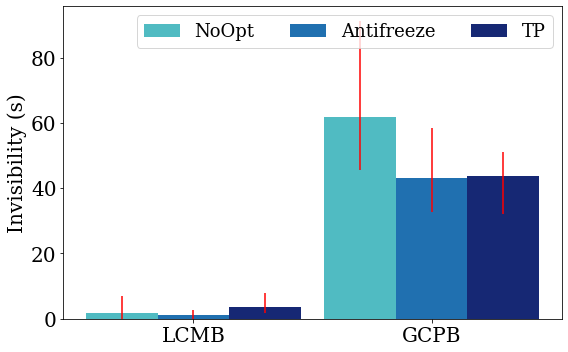

In [108]:
pdf_path = f'{notebook_home}/{opt_str}_random_regular_change_iv.pdf'
draw_group_bar_charts(df=iv_df,
                      group_label_header=mvc_str,
                      bar_label_header=opt_str,
                      y_axis_header=agg_value,
                      y_label=config_name_dict[iv_str],
                      fig_size=opt_fig_size,
                      y_tick_max=opt_iv_max,
                      y_tick_num=num_y_ticks,
                      bar_width=opt_bar_width,
                      legend_size=opt_legend_size,
                      x_tick_size=x_tick_size,
                      y_tick_size=y_tick_size,
                      y_label_size=y_label_size,
                      group_label_dict=mvc_name_dict,
                      bar_label_dict=opt_name_dict,
                      bar_label_color_dict=opt_color_dict,
                      pdf_path=pdf_path,
                      ncol=ncol)

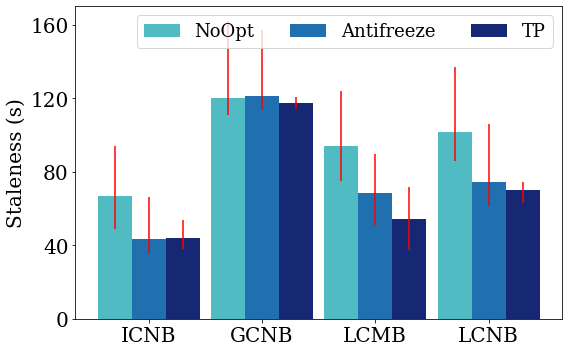

In [109]:
sl_df = massage_data(agg_df, sl_str)
pdf_path = f'{notebook_home}/{opt_str}_random_regular_change_sl.pdf'
draw_group_bar_charts(df=sl_df,
                      group_label_header=mvc_str,
                      bar_label_header=opt_str,
                      y_axis_header=agg_value,
                      y_label=config_name_dict[sl_str],
                      fig_size=opt_fig_size,
                      y_tick_max=opt_sl_max,
                      y_tick_num=num_y_ticks,
                      bar_width=opt_bar_width,
                      legend_size=opt_legend_size,
                      x_tick_size=x_tick_size,
                      y_tick_size=y_tick_size,
                      y_label_size=y_label_size,
                      group_label_dict=mvc_name_dict,
                      bar_label_dict=opt_name_dict,
                      bar_label_color_dict=opt_color_dict,
                      pdf_path=pdf_path,
                      ncol=ncol)

In [110]:
rnd_iv_df = iv_df.set_index([mvc_str, opt_str])
rnd_sl_df = sl_df.set_index([mvc_str, opt_str])

In [111]:
result_home = os.path.join(experiment_home, opt_str, "regular_change")
raw_df = read_raw_data_for_optimizations(result_home)
raw_df = raw_df[raw_df["optimization"] != "optimization_false_true"]
agg_df = raw_df.drop([run_str], axis=1).groupby([mvc_str, opt_str]).agg([agg_value, "min", "max"])
agg_df

invisibility                    \
                                                 mean      min      max   
mvc_properties optimization                                               
1              optimization_false_false      0.000000      0.0      0.0   
               optimization_true_false       0.000000      0.0      0.0   
               optimization_true_true        0.000000      0.0      0.0   
2              optimization_false_false      0.000000      0.0      0.0   
               optimization_true_false       0.000000      0.0      0.0   
...                                               ...      ...      ...   
4              optimization_true_false   41166.666667  40900.0  41500.0   
               optimization_true_true    43833.333333  43100.0  44300.0   
5              optimization_false_false      0.000000      0.0      0.0   
               optimization_true_false       0.000000      0.0      0.0   
               optimization_true_true        0.000000      0.0      0.0   

                                             staleness                      \
                                                  mean       min       max   
mvc_properties optimization                                                  
1              optimization_false_false   60900.000000   59500.0   62300.0   
               optimization_true_false    41066.666667   40800.0   41300.0   
               optimization_true_true     44666.666667   43900.0   45300.0   
2              optimization_false_false  116933.333333  116400.0  118000.0   
               optimization_true_false   114800.000000  114400.0  115200.0   
...                                                ...       ...       ...   
4              optimization_true_false        0.000000       0.0       0.0   
               optimization_true_true         0.000000       0.0       0.0   
5              optimization_false_false   95200.000000   85600.0  102800.0   
               optimization_true_false    76133.333333   75200.0   77200.0   
               optimization_true_true     60933.333333   58400.0   62800.0   

                                                 iv_sl                      \
                                                  mean       min       max   
mvc_properties optimization                                                  
1              optimization_false_false   60900.000000   59500.0   62300.0   
               optimization_true_false    41066.666667   40800.0   41300.0   
               optimization_true_true     44666.666667   43900.0   45300.0   
2              optimization_false_false  116933.333333  116400.0  118000.0   
               optimization_true_false   114800.000000  114400.0  115200.0   
...                                                ...       ...       ...   
4              optimization_true_false    41166.666667   40900.0   41500.0   
               optimization_true_true     43833.333333   43100.0   44300.0   
5              optimization_false_false   95200.000000   85600.0  102800.0   
               optimization_true_false    76133.333333   75200.0   77200.0   
               optimization_true_true     60933.333333   58400.0   62800.0   

                                           total_time                    
                                                 mean      min      max  
mvc_properties optimization                                              
1              optimization_false_false  29233.333333  29000.0  29600.0  
               optimization_true_false   28866.666667  28700.0  29000.0  
               optimization_true_true    28900.000000  28900.0  28900.0  
2              optimization_false_false  29333.333333  29200.0  29600.0  
               optimization_true_false   28800.000000  28700.0  28900.0  
...                                               ...      ...      ...  
4              optimization_true_false   28900.000000  28900.0  28900.0  
               optimization_true_true    28833.333333  28600.0  

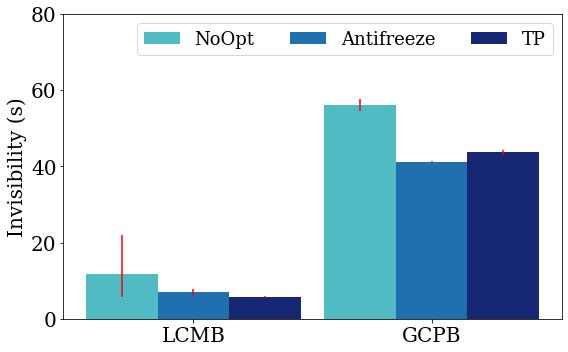

In [112]:
iv_df = massage_data(agg_df, iv_str)
pdf_path = f'{notebook_home}/{opt_str}_regular_change_iv.pdf'
draw_group_bar_charts(df=iv_df,
                      group_label_header=mvc_str,
                      bar_label_header=opt_str,
                      y_axis_header=agg_value,
                      y_label=config_name_dict[iv_str],
                      fig_size=opt_fig_size,
                      y_tick_max=opt_iv_max,
                      y_tick_num=num_y_ticks,
                      bar_width=opt_bar_width,
                      legend_size=opt_legend_size,
                      x_tick_size=x_tick_size,
                      y_tick_size=y_tick_size,
                      y_label_size=y_label_size,
                      group_label_dict=mvc_name_dict,
                      bar_label_dict=opt_name_dict,
                      bar_label_color_dict=opt_color_dict,
                      pdf_path=pdf_path,
                      ncol=ncol)

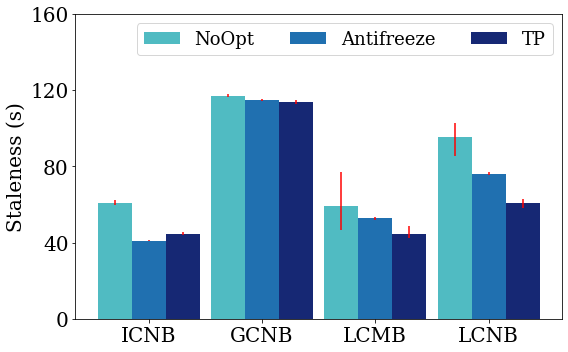

In [113]:
sl_df = massage_data(agg_df, sl_str)
pdf_path = f'{notebook_home}/{opt_str}_regular_change_sl.pdf'
draw_group_bar_charts(df=sl_df,
                      group_label_header=mvc_str,
                      bar_label_header=opt_str,
                      y_axis_header=agg_value,
                      y_label=config_name_dict[sl_str],
                      fig_size=opt_fig_size,
                      y_tick_max=opt_sl_max,
                      y_tick_num=num_y_ticks,
                      bar_width=opt_bar_width,
                      legend_size=opt_legend_size,
                      x_tick_size=x_tick_size,
                      y_tick_size=y_tick_size,
                      y_label_size=y_label_size,
                      group_label_dict=mvc_name_dict,
                      bar_label_dict=opt_name_dict,
                      bar_label_color_dict=opt_color_dict,
                      pdf_path=pdf_path,
                      ncol=ncol)

In [114]:
reg_iv_df = iv_df.set_index([mvc_str, opt_str])
reg_sl_df = sl_df.set_index([mvc_str, opt_str])

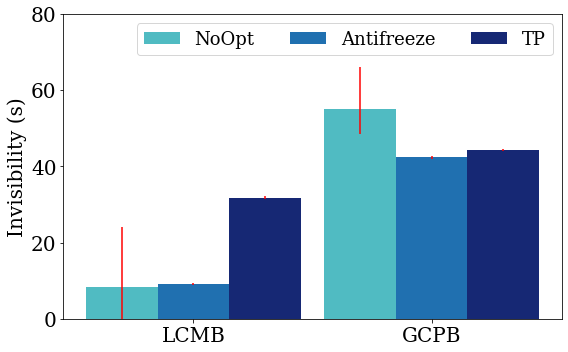

In [115]:
result_home = os.path.join(experiment_home, opt_str, "see_change")
raw_df = read_raw_data_for_optimizations(result_home)
raw_df = raw_df[raw_df["optimization"] != "optimization_false_true"]
agg_df = raw_df.drop([run_str], axis=1).groupby([mvc_str, opt_str]).agg([agg_value, "min", "max"])
iv_df = massage_data(agg_df, iv_str)
pdf_path = f'{notebook_home}/{opt_str}_see_change_iv.pdf'
draw_group_bar_charts(df=iv_df,
                      group_label_header=mvc_str,
                      bar_label_header=opt_str,
                      y_axis_header=agg_value,
                      y_label=config_name_dict[iv_str],
                      fig_size=opt_fig_size,
                      y_tick_max=opt_iv_max,
                      y_tick_num=num_y_ticks,
                      bar_width=opt_bar_width,
                      legend_size=opt_legend_size,
                      x_tick_size=x_tick_size,
                      y_tick_size=y_tick_size,
                      y_label_size=y_label_size,
                      group_label_dict=mvc_name_dict,
                      bar_label_dict=opt_name_dict,
                      bar_label_color_dict=opt_color_dict,
                      pdf_path=pdf_path,
                      ncol=ncol)

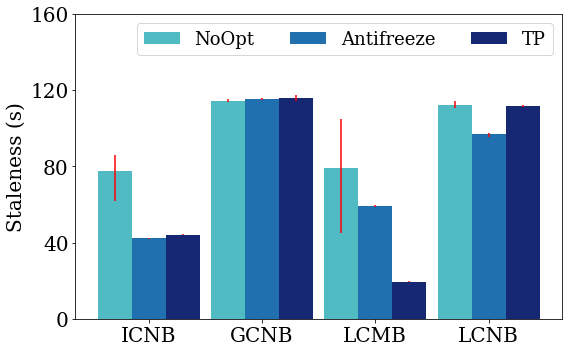

In [116]:
sl_df = massage_data(agg_df, sl_str)
pdf_path = f'{notebook_home}/{opt_str}_see_change_sl.pdf'
draw_group_bar_charts(df=sl_df,
                      group_label_header=mvc_str,
                      bar_label_header=opt_str,
                      y_axis_header=agg_value,
                      y_label=config_name_dict[sl_str],
                      fig_size=opt_fig_size,
                      y_tick_max=opt_sl_max,
                      y_tick_num=num_y_ticks,
                      bar_width=opt_bar_width,
                      legend_size=opt_legend_size,
                      x_tick_size=x_tick_size,
                      y_tick_size=y_tick_size,
                      y_label_size=y_label_size,
                      group_label_dict=mvc_name_dict,
                      bar_label_dict=opt_name_dict,
                      bar_label_color_dict=opt_color_dict,
                      pdf_path=pdf_path,
                      ncol=ncol)

In [117]:
see_iv_df = iv_df.set_index([mvc_str, opt_str])
see_sl_df = sl_df.set_index([mvc_str, opt_str])

In [118]:
def compute_diff(df, mvc_property, opt_one, opt_two):
    return 1 - df.loc[mvc_property, opt_one][agg_value]/df.loc[mvc_property, opt_two][agg_value]